# load and import ACC Dataset

In [4]:
#Import helper functions
# Download the script
!wget https://raw.githubusercontent.com/danishtdk/respai/main/helper_function.py

# Import functions
from helper_function import walk_through_dir, plot_loss_curves, unzip_data, make_confusion_matrix, create_tensorboard_callback

--2022-04-27 07:15:20--  https://raw.githubusercontent.com/danishtdk/respai/main/helper_function.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 11531 (11K) [text/plain]
Saving to: ‘helper_function.py.1’

helper_function.py. 100%[===================>]  11.26K  --.-KB/s    in 0s      

2022-04-27 07:15:21 (82.2 MB/s) - ‘helper_function.py.1’ saved [11531/11531]



In [5]:
# Mount gdrive
from google.colab import drive
drive.mount('/content/drive/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [6]:
# Load and unzip the dataset
unzip_data('/content/drive/MyDrive/Colab_Notebooks/yield_notyield/fig_0.5s/acc0s.zip')

# Getting accustomed to data

In [7]:
# Walk thrugh directory
DATA_DIR = '/content/acc'
walk_through_dir(DATA_DIR)

There are 2 directories and 0 images in '/content/acc'.
There are 0 directories and 449 images in '/content/acc/not_yield'.
There are 0 directories and 347 images in '/content/acc/over_yield'.


In [8]:
# Data visualization (view random image)
import random
import os
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

CLASS_NAMES = sorted(os.listdir(DATA_DIR))

def view_random_image(target_folder):

  '''View Random Image from the random class of the target directory'''
  
  random_class = random.choice(CLASS_NAMES)
  random_image = random.sample(os.listdir(os.path.join(target_folder, random_class)), 1)
  random_image_path = os.path.join(target_folder, random_class, random_image[0])
  img = mpimg.imread(random_image_path)
  plt.imshow(img)
  print(f'Image Shape: {img.shape}')
  plt.title(random_class)
  plt.axis('off')

  return img

Image Shape: (480, 640, 4)


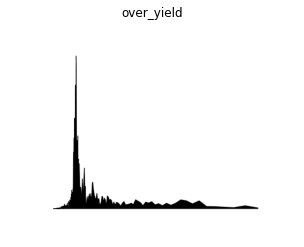

In [9]:
img = view_random_image('/content/acc')

# Data Preprocessing

## Split into train and test set (0.9, 0.1)

In [10]:
from helper_function import split_train_test
split_train_test(DATA_DIR, CLASS_NAMES, test_ratio=0.1)

## Rescale & resize the images, and create batches 

In [11]:
import tensorflow as tf

train_dir = os.path.join(DATA_DIR, 'train') 
test_dir = os.path.join(DATA_DIR, 'test')
IMG_SIZE = (224, 224)
BATCH_SIZE = 32

train_datagen = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255, validation_split=0.1)
test_datagen = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255)

train_data = train_datagen.flow_from_directory(directory=train_dir,
                                         batch_size=BATCH_SIZE,
                                         target_size=IMG_SIZE,
                                         class_mode='binary',
                                         subset='training')
valid_data = train_datagen.flow_from_directory(directory=train_dir,
                                         batch_size=BATCH_SIZE,
                                         target_size=IMG_SIZE,
                                         class_mode='binary',
                                         subset='validation')

Found 645 images belonging to 2 classes.
Found 71 images belonging to 2 classes.


# CNN Models (Experiments)

### Requirements

In [12]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPool2D, Flatten, Dense

## Model 1 (baseline model)

In [13]:
# Create, compile and fit the model
model_1 = tf.keras.Sequential([Conv2D(10, 3, activation='relu', input_shape=(224, 224, 3)),
                               Conv2D(10, 3, activation='relu'),
                               Conv2D(10, 3, activation='relu'),
                               Flatten(),
                               Dense(1, activation='sigmoid')])

model_1.compile(loss='binary_crossentropy',
                optimizer='Adam',
                metrics=['accuracy'])

history_1 = model_1.fit(train_data, 
                        epochs = 20,
                        steps_per_epoch = len(train_data),
                        validation_data = valid_data,
                        validation_steps= len(valid_data),
                        callbacks=[create_tensorboard_callback(dir_name='tfmodels_log',
                                                             experiment_name='model_1')])

Saving TensorBoard log files to: tfmodels_log/model_1/20220427-071526
Epoch 1/20
21/21 [==============================] - 17s 263ms/step - loss: 8.6534 - accuracy: 0.5225 - val_loss: 0.5805 - val_accuracy: 0.6761
Epoch 2/20
21/21 [==============================] - 5s 233ms/step - loss: 0.3874 - accuracy: 0.8791 - val_loss: 0.3439 - val_accuracy: 0.8732
Epoch 3/20
21/21 [==============================] - 5s 231ms/step - loss: 0.2747 - accuracy: 0.9070 - val_loss: 0.2206 - val_accuracy: 0.9859
Epoch 4/20
21/21 [==============================] - 5s 234ms/step - loss: 0.1792 - accuracy: 0.9535 - val_loss: 0.1892 - val_accuracy: 0.9296
Epoch 5/20
21/21 [==============================] - 5s 234ms/step - loss: 0.1477 - accuracy: 0.9566 - val_loss: 0.1476 - val_accuracy: 0.9859
Epoch 6/20
21/21 [==============================] - 5s 233ms/step - loss: 0.1188 - accuracy: 0.9581 - val_loss: 0.1135 - val_accuracy: 0.9718
Epoch 7/20
21/21 [==============================] - 5s 231ms/step - loss: 0.1

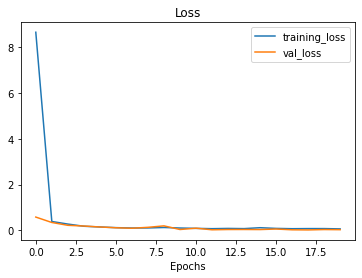

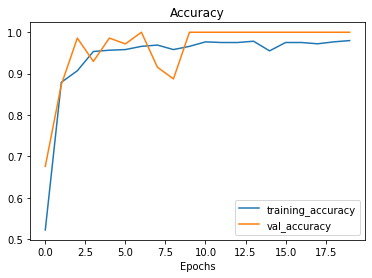

In [14]:
# View training/loss curves
plot_loss_curves(history_1)

## Model 2

In [15]:
# Create, compile and fit the model
model_2 = tf.keras.Sequential([Conv2D(10, 3, activation='relu', input_shape=(224, 224, 3)),
                               MaxPool2D(),
                               Conv2D(10, 3, activation='relu'),
                               MaxPool2D(),
                               Conv2D(10, 3, activation='relu'),
                               MaxPool2D(),
                               Flatten(),
                               Dense(1, activation='sigmoid')])

model_2.compile(loss='binary_crossentropy',
                optimizer='Adam',
                metrics=['accuracy'])

history_2 = model_2.fit(train_data, 
                        epochs = 20,
                        steps_per_epoch = len(train_data),
                        validation_data = valid_data,
                        validation_steps= len(valid_data),
                        callbacks=[create_tensorboard_callback(dir_name='tfmodels_log',
                                                             experiment_name='model_2')])

Saving TensorBoard log files to: tfmodels_log/model_2/20220427-071719
Epoch 1/20
21/21 [==============================] - 6s 244ms/step - loss: 0.6805 - accuracy: 0.6078 - val_loss: 0.6262 - val_accuracy: 0.5634
Epoch 2/20
21/21 [==============================] - 5s 218ms/step - loss: 0.5688 - accuracy: 0.6775 - val_loss: 0.5200 - val_accuracy: 0.7606
Epoch 3/20
21/21 [==============================] - 5s 216ms/step - loss: 0.4502 - accuracy: 0.7736 - val_loss: 0.4167 - val_accuracy: 0.9296
Epoch 4/20
21/21 [==============================] - 5s 215ms/step - loss: 0.4027 - accuracy: 0.7535 - val_loss: 0.3935 - val_accuracy: 0.7606
Epoch 5/20
21/21 [==============================] - 5s 214ms/step - loss: 0.3706 - accuracy: 0.8419 - val_loss: 0.4234 - val_accuracy: 0.7606
Epoch 6/20
21/21 [==============================] - 5s 214ms/step - loss: 0.3225 - accuracy: 0.8558 - val_loss: 0.3617 - val_accuracy: 0.7606
Epoch 7/20
21/21 [==============================] - 5s 217ms/step - loss: 0.29

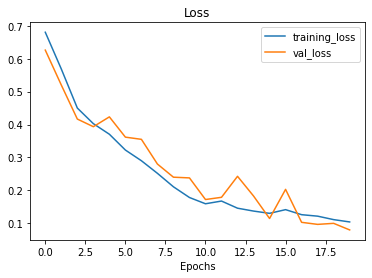

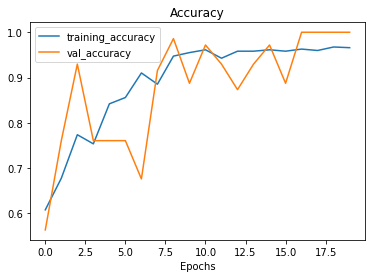

In [16]:
# View training/loss curves
plot_loss_curves(history_2)

## Model 3 (Replicating https://poloclub.github.io/cnn-explainer/)

In [17]:
# Create, compile and fit the model
model_3 = tf.keras.Sequential([Conv2D(10, 3, activation='relu', input_shape=(224, 224, 3)),
                               Conv2D(10, 3, activation='relu'),
                               MaxPool2D(),
                               Conv2D(10, 3, activation='relu'),
                               Conv2D(10, 3, activation='relu'),
                               MaxPool2D(),
                               Conv2D(10, 3, activation='relu'),
                               Conv2D(10, 3, activation='relu'),
                               MaxPool2D(),
                               Flatten(),
                               Dense(1, activation='sigmoid')])

model_3.compile(loss='binary_crossentropy',
                optimizer='Adam',
                metrics=['accuracy'])

history_3 = model_3.fit(train_data, 
                        epochs = 5,
                        steps_per_epoch = len(train_data),
                        validation_data = valid_data,
                        validation_steps= len(valid_data),
                        callbacks=[create_tensorboard_callback(dir_name='tfmodels_log',
                                                             experiment_name='model_3')])

Saving TensorBoard log files to: tfmodels_log/model_3/20220427-071854
Epoch 1/5
21/21 [==============================] - 6s 250ms/step - loss: 0.6213 - accuracy: 0.6589 - val_loss: 0.5077 - val_accuracy: 0.9296
Epoch 2/5
21/21 [==============================] - 5s 231ms/step - loss: 0.4319 - accuracy: 0.7426 - val_loss: 0.3794 - val_accuracy: 0.9718
Epoch 3/5
21/21 [==============================] - 5s 232ms/step - loss: 0.3276 - accuracy: 0.8667 - val_loss: 0.4195 - val_accuracy: 0.7606
Epoch 4/5
21/21 [==============================] - 5s 230ms/step - loss: 0.2372 - accuracy: 0.9194 - val_loss: 0.2408 - val_accuracy: 0.9014
Epoch 5/5
21/21 [==============================] - 5s 230ms/step - loss: 0.2311 - accuracy: 0.9178 - val_loss: 0.3581 - val_accuracy: 0.7465


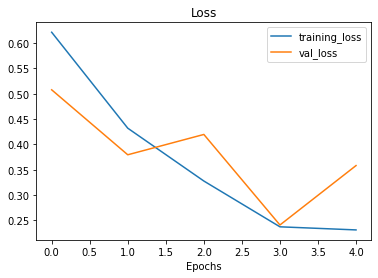

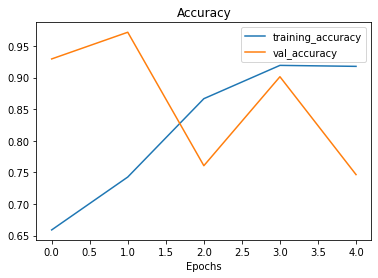

In [18]:
# View training/loss curves
plot_loss_curves(history_3)

# Evaluating Model Performances Using Tensorboard

In [ ]:
# Upload tensorflow experiment:
!tensorboard dev upload --logdir /content/tfmodels_log/ \
   --name "CNN Models (Experiments)" \
   --description "Comparing different CNN models trained on images of the acceleration response spectrum to predict whether yielding has occurred in a bilinear model with a single mass (eigen period 0.5 s)." \
   --one_shot


***** TensorBoard Uploader *****

This will upload your TensorBoard logs to https://tensorboard.dev/ from
the following directory:

/content/tfmodels_log/

This TensorBoard will be visible to everyone. Do not upload sensitive
data.

Your use of this service is subject to Google's Terms of Service
<https://policies.google.com/terms> and Privacy Policy
<https://policies.google.com/privacy>, and TensorBoard.dev's Terms of Service
<https://tensorboard.dev/policy/terms/>.

This notice will not be shown again while you are logged into the uploader.
To log out, run `tensorboard dev auth revoke`.

Continue? (yes/NO) NO
NO


## Tensorboard dev link: https://tensorboard.dev/experiment/7u496166Rqei6IQxwCvJqw/

In [ ]:
!tensorboard dev list


***** TensorBoard Uploader *****

This will list all experiments that you've uploaded to
https://tensorboard.dev. TensorBoard.dev experiments are visible
to everyone. Do not upload sensitive data.

Your use of this service is subject to Google's Terms of Service
<https://policies.google.com/terms> and Privacy Policy
<https://policies.google.com/privacy>, and TensorBoard.dev's Terms of Service
<https://tensorboard.dev/policy/terms/>.

This notice will not be shown again while you are logged into the uploader.
To log out, run `tensorboard dev auth revoke`.

Continue? (yes/NO) NO


## Delete the experiments for security reasons

In [ ]:
!tensorboard dev delete --experiment_id 7u496166Rqei6IQxwCvJqw

NO

***** TensorBoard Uploader *****

This will delete the 1 experiment(s) on
https://tensorboard.dev with the following experiment ID(s):

['7u496166Rqei6IQxwCvJqw']

You have chosen to delete an experiment. All experiments uploaded
to TensorBoard.dev are publicly visible. Do not upload sensitive
data.

Your use of this service is subject to Google's Terms of Service
<https://policies.google.com/terms> and Privacy Policy
<https://policies.google.com/privacy>, and TensorBoard.dev's Terms of Service
<https://tensorboard.dev/policy/terms/>.

This notice will not be shown again while you are logged into the uploader.
To log out, run `tensorboard dev auth revoke`.

Continue? (yes/NO) 

In [ ]:
!tensorboard dev list


***** TensorBoard Uploader *****

This will list all experiments that you've uploaded to
https://tensorboard.dev. TensorBoard.dev experiments are visible
to everyone. Do not upload sensitive data.

Your use of this service is subject to Google's Terms of Service
<https://policies.google.com/terms> and Privacy Policy
<https://policies.google.com/privacy>, and TensorBoard.dev's Terms of Service
<https://tensorboard.dev/policy/terms/>.

This notice will not be shown again while you are logged into the uploader.
To log out, run `tensorboard dev auth revoke`.

Continue? (yes/NO) NO


# Predictions on custome image

In [20]:
# Create a function to import an image and resize it to be able to be used with our model
def load_and_prep_image(filename, img_shape=224, scale=True):
  """
  Reads in an image from filename, turns it into a tensor and reshapes into
  (224, 224, 3).

  Parameters
  ----------
  filename (str): string filename of target image
  img_shape (int): size to resize target image to, default 224
  scale (bool): whether to scale pixel values to range(0, 1), default True
  """
  # Read in the image
  img = tf.io.read_file(filename)
  # Decode it into a tensor
  img = tf.io.decode_image(img, channels=3)
  # Resize the image
  img = tf.image.resize(img, [img_shape, img_shape])
  if scale:
    # Rescale the image (get all values between 0 and 1)
    return img/255.
  else:
    return img

In [21]:
# Make a function to predict on images and plot them (works with multi-class)
def pred_and_plot(model, filename, class_names):
  """
  Imports an image located at filename, makes a prediction on it with
  a trained model and plots the image with the predicted class as the title.
  """
  # Import the target image and preprocess it
  img = load_and_prep_image(filename)

  # Make a prediction
  pred = model.predict(tf.expand_dims(img, axis=0))

  # Get the predicted class
  if len(pred[0]) > 1: # check for multi-class
    pred_class = class_names[pred.argmax()] # if more than one output, take the max
  else:
    pred_class = class_names[int(tf.round(pred)[0][0])] # if only one output, round

  # Plot the image and predicted class
  plt.imshow(img)
  plt.title(f"Prediction: {pred_class}")
  plt.axis(False);

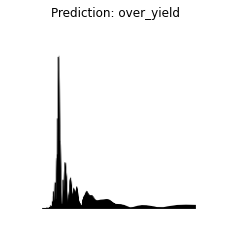

In [22]:
pred_and_plot(model_2, '/content/acc/over_yield/58-wave4-fourier.png', class_names=CLASS_NAMES)

# Plot Confusion Metrics for detail evaluation

In [23]:
test_data = test_datagen.flow_from_directory(directory=test_dir,
                                             batch_size=BATCH_SIZE,
                                             target_size=IMG_SIZE,
                                             class_mode='binary',
                                             shuffle=False)

Found 80 images belonging to 2 classes.


In [24]:
filenames = test_data.filenames
nb_samples = len(filenames)

predict = model_2.predict_generator(test_data,steps = nb_samples)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  after removing the cwd from sys.path.


In [25]:
import numpy as np

pred_labels = tf.squeeze(tf.transpose(np.where(predict>0.5, 1, 0)))
pred_labels

<tf.Tensor: shape=(80,), dtype=int64, numpy=
array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0])>

In [26]:
test_labels = test_data.classes
test_labels

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], dtype=int32)

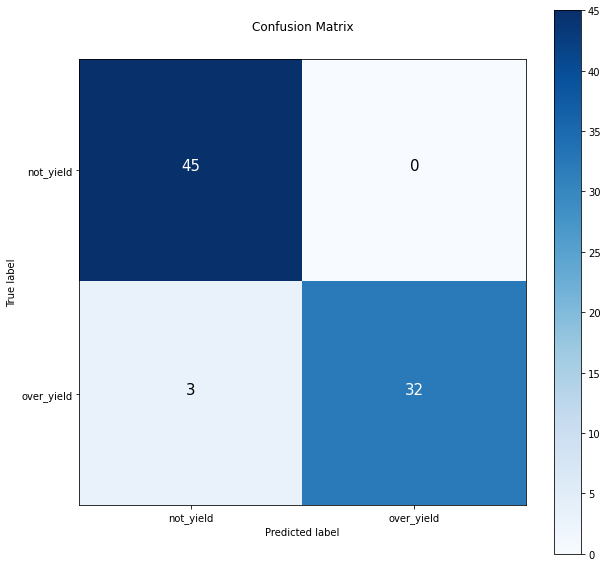

In [27]:
from sklearn.metrics import confusion_matrix
make_confusion_matrix(y_true=test_labels, y_pred=pred_labels, classes=CLASS_NAMES)

In [28]:
from sklearn.metrics import classification_report
print(classification_report(test_labels, pred_labels, target_names=CLASS_NAMES))

              precision    recall  f1-score   support

   not_yield       0.94      1.00      0.97        45
  over_yield       1.00      0.91      0.96        35

    accuracy                           0.96        80
   macro avg       0.97      0.96      0.96        80
weighted avg       0.96      0.96      0.96        80



# Save the Model Weigths and Architechture

In [31]:
model_2.save('/content/drive/MyDrive/Colab_Notebooks/yield_notyield/fig_0.5s')

INFO:tensorflow:Assets written to: /content/drive/MyDrive/Colab_Notebooks/yield_notyield/fig_0.5s/assets
